In [1]:
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, Label

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ultralytics import YOLO
import torch
import comet_ml
from comet_ml import Experiment
from comet_ml import Optimizer

import cv2
import PIL.Image as Image

import os
import shutil
import pathlib
import sys
import yaml

In [2]:
# go to parent directory
os.chdir("../..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs/detection"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"
dataset_yaml = ROOT_DIR / "dataset.yaml"
SLIDES_PATH = ROOT_DIR / "slides"

# set path to repo_dir
os.chdir(REPO_DIR)

## Dataset


### Dataset & Model Constants

In [3]:
PROJECT_NAME = "dog_breed_detection"

RANDOM_SEED = 42
IMAGE_SIZE = 640

BATCH_SIZE = 2          # Platform Dependent; 
                            # 32-64 for rtX 5000 series
                            # 1-4 for mac m1
DEVICE = "mps"         # Platform Dependent. mps, cuda(0, 1, ...), cpu

yaml_file_path = ROOT_DIR / "dataset.yaml"
with open(yaml_file_path, "r") as f:
    dataset_details = yaml.safe_load(f)

NUM_CLASSES = len(dataset_details["names"])
CLASS_NAMES = dataset_details["names"]

In [4]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Dataset Explore

In [5]:
dataset_df = pd.read_csv(DATA_BASE_PATH / "dogs_df.csv")
dataset_df.head()

,breed,image_path,annotation_path,new_annotation_path
0,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
2,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
3,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
4,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...


In [6]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

def render_results(
    image, 
    boxes: list[float], 
    classes: list[int],
    give_labels: bool = True,
):
    # image - single image
    # boxes - list of boxes; box = [x, y, w, h]
    # labels - list of labels; label = int
    
    cmap = plt.get_cmap("tab20b")
    colors = np.array([cmap(i%20)[:-1] for i in range(NUM_CLASSES)]) * 255
    
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_h, image_w, _ = image_cv.shape
    
    for box, cls in zip(boxes, classes):
        x, y, w, h = box
        x, y, w, h = (
            x * image_w,
            y * image_h,
            w * image_w,
            h * image_h
        )
        
        x1, x2 = int(x - w / 2), int(x + w / 2)
        y1, y2 = int(y - h / 2), int(y + h / 2)
        
        b_col = colors[int(cls)]
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), b_col, 2)
        cls_name = CLASS_NAMES[int(cls)]
        
        # add text
        if give_labels:
            text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            text_position = (x1 + 1, y2 - 2)
            
            image_cv = cv2.rectangle(
                image_cv,
                (x1, y2),
                (x1 + text_size[0], y2 - text_size[1] - 4),
                b_col,
                -1,  # filled rectangle
            )
            image_cv = cv2.putText(
                image_cv, 
                cls_name, 
                text_position, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, 
                (255, 255, 255), 
                2,
                cv2.LINE_AA,
                False,
            )
        
    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        
    return image


In [7]:
slide_vars = {}

def image_slider(images, slide_name=None, num_images=8):
    slide_name = slide_name or np.random.randint(0, 100000)
    if num_images > len(images) or num_images == -1:
        num_images = len(images)

    def save_as_slides(slide_name, images):
        save_path = SLIDES_PATH / f"slide_{slide_name}"

        os.makedirs(save_path, exist_ok=True)
        try:
            shutil.rmtree(save_path)
            os.makedirs(save_path)
            for image in images:
                image = Image.fromarray(image)
                image.save(save_path / f"{np.random.randint(0, 100000)}.jpg")
        except Exception as e:
            print(e)
            print("Error while saving images as slides")

    def load_slides(slide_num) -> list:
        slide_path = ROOT_DIR / f"slides/slide_{slide_num}"
        images = [str(slide_path / image) for image in os.listdir(slide_path) if image.endswith(".jpg")]
        return str(slide_path), images

    save_as_slides(slide_name, images[:num_images])
    _, images = load_slides(slide_name)

    global slide_vars
    slide_vars[slide_name] = {"image_index": 0}
    current_slide = slide_vars[slide_name]

    # Show image
    def show_image():
        clear_output(wait=True)
        display(HBox([current_slide["previous_button"], current_slide["index_label"],current_slide["next_button"],],layout={'justify_content': 'center'}))
        image_path = images[current_slide["image_index"]]
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def update_label():
        current_slide["index_label"].value = f"{current_slide['image_index'] + 1}/{num_images}"

    def button_click(step):
        current_slide = slide_vars[slide_name]

        idx = current_slide["image_index"] + step
        idx = idx % num_images
        current_slide["image_index"] = idx
        update_label()
        show_image()

    previous_button = Button(description='Previous', button_style='info', layout={'width': 'auto'})
    previous_button.on_click(lambda x: button_click(-1))
    current_slide["previous_button"] = previous_button

    next_button = Button(description='Next', button_style='info', layout={'width': 'auto'})
    next_button.on_click(lambda x: button_click(1))
    current_slide["next_button"] = next_button

    index_label = Label(value=f"{current_slide['image_index'] + 1}/{num_images}")
    current_slide["index_label"] = index_label
    
    show_image()
    


In [8]:
data_sample = dataset_df.sample(8)

images, all_boxes, all_classes = [], [], []

for image_path, annotation_path in zip(data_sample["image_path"], data_sample["new_annotation_path"]):
    image = load_image(image_path)
    images.append(image)

    boxes, classes = [], []
    with open(annotation_path, "r") as f:
        data = f.readlines()
        
    for line in data:
        cls_, x, y, w, h = line.split()
        cls_, x, y, w, h = int(cls_), float(x), float(y), float(w), float(h)
        boxes.append([x, y, w, h])
        classes.append(cls_)
            
    all_boxes.append(boxes)
    all_classes.append(classes)

all_classes

[[94], [18], [116], [7], [114], [34], [117], [110]]

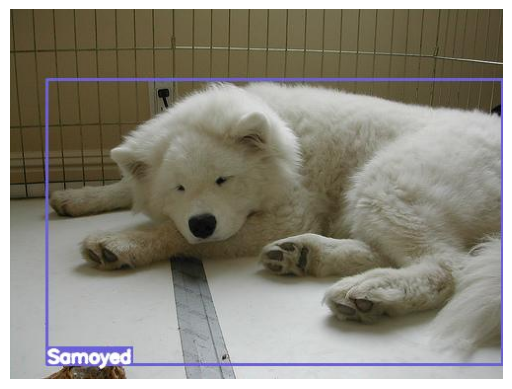

In [9]:
slide_name = 1

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes[idx]
    classes = all_classes[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name)

result_images = None

## Model

#### Basic inferance

In [272]:
import requests

image_src = "https://thumbor.forbes.com/thumbor/fit-in/900x510/https://www.forbes.com/advisor/wp-content/uploads/2021/03/dog-group.jpg"
image = np.array(Image.open(requests.get(image_src, stream=True).raw))

image_path = "/Users/vineetmahajan/Downloads/dogbreeds-1.jpg"
image = np.array(Image.open(image_path))
image.shape

(1920, 2560, 3)


0: 480x640 9 dogs, 1 sheep, 338.9ms
Speed: 2.6ms preprocess, 338.9ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict7


tensor([16., 16., 16., 16., 16., 16., 16., 16., 16., 18.])


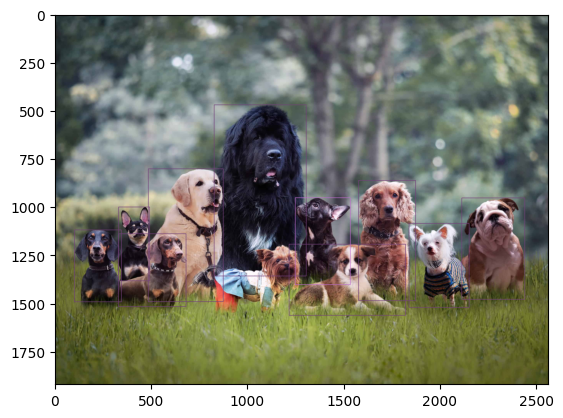

In [273]:
weight = "yolov8m-seg.pt"
model = YOLO(weight)
result = model.predict(image, save=True)[0]
result_ = result

boxes = result.boxes.xywhn
classes = result.boxes.cls
result = render_results(image, boxes, classes, give_labels=False)
plt.imshow(result)

print(classes)

In [274]:
image.shape

(1920, 2560, 3)

In [275]:
# Scale Image
output_image_longer_side = 640
h, w, _ = image.shape
scale = output_image_longer_side / max(h, w)

if h < w:
    new_h, new_w = round(h*scale/32)*32, output_image_longer_side
else:
    new_h, new_w = output_image_longer_side, round(h*scale/32)*32
    
new_h, new_w

(480, 640)

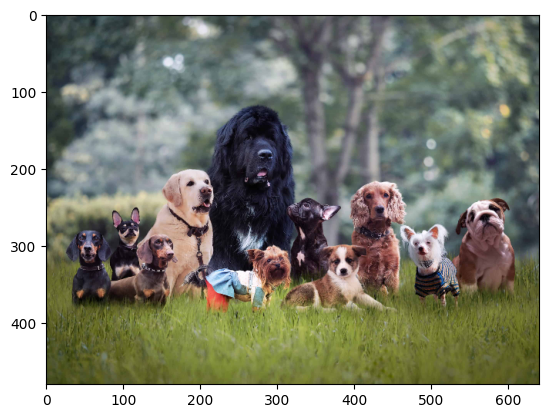

In [276]:
scaled_image = cv2.resize(image, (new_w, new_h))
plt.imshow(scaled_image)

In [277]:
mask_data = model.predict(scaled_image, save=True)[0].masks.data.cpu().numpy()
mask_data.shape


0: 480x640 9 dogs, 1 sheep, 377.9ms
Speed: 1.2ms preprocess, 377.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict7


(10, 480, 640)

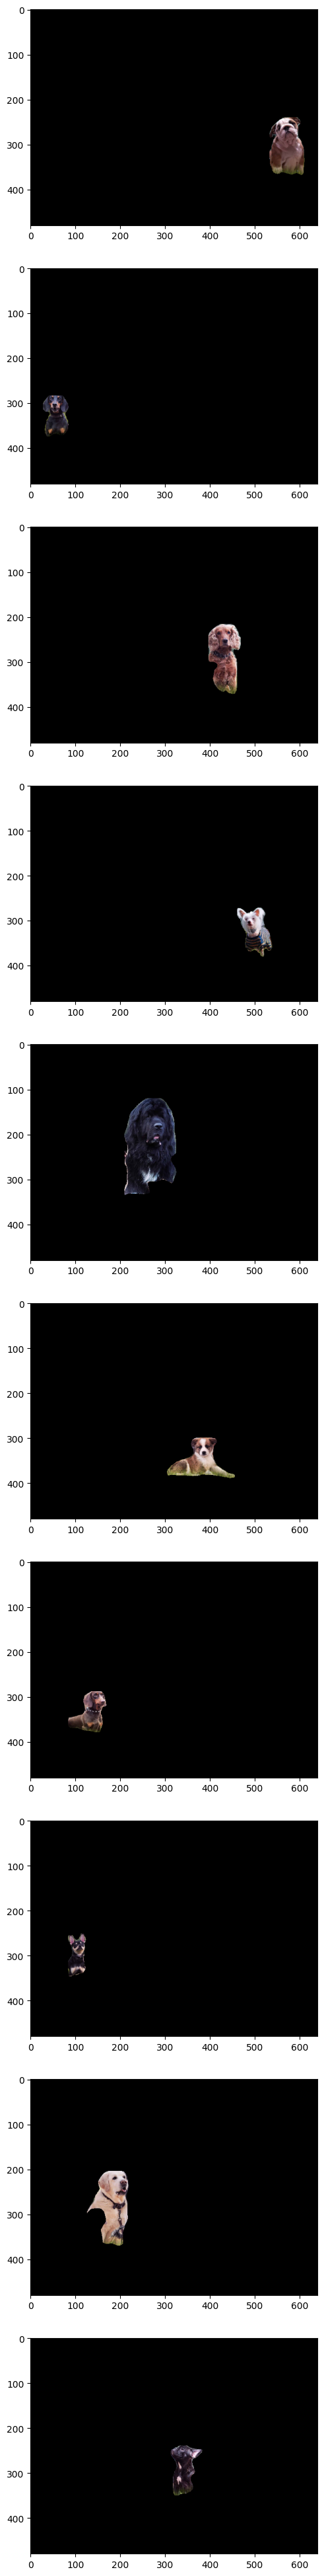

In [284]:
plt.figure(figsize=(10, 50))

total_dogs = len(mask_data) 
for idx, mask in enumerate(mask_data):
    # plt.subplot(total_dogs , 3, 3*idx + 1)
    # plt.imshow(image)
    
    # plt.subplot(total_dogs , 3, 3*idx + 2)
    mask = np.expand_dims(mask, axis=-1)
    # plt.imshow(mask, cmap="gray")
    
    plt.subplot(total_dogs , 1, idx + 1)
    masked_image = (mask * scaled_image).astype(np.uint8)
    plt.imshow(masked_image)

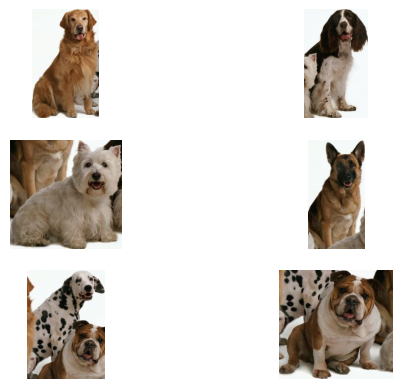

In [37]:
dog_boxes = []
image_h, image_w, _ = image.shape
for box in boxes:
    if 1:
        x1 = int((box[0] - box[2] / 2) * image_w)
        x2 = int((box[0] + box[2] / 2) * image_w)
        y1 = int((box[1] - box[3] / 2) * image_h)
        y2 = int((box[1] + box[3] / 2) * image_h)
        dog_image = image[y1:y2, x1:x2]
        dog_boxes.append(dog_image)
        

total_dogs = len(dog_boxes)
for idx in range(total_dogs):
    plt.subplot(total_dogs // 2, 2, idx + 1)
    plt.imshow(dog_boxes[idx])
    plt.axis('off')

In [28]:
image.crop((box[0], box[1], box[0] + box[2], box[1] + box[3]))

NameError: name 'box' is not defined

In [11]:
# # image = results[0].orig_img
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# boxes = results[0].boxes.xywhn
# classes = results[0].boxes.cls

# result_image = render_results(image, boxes, classes, give_labels=False)
# plt.imshow(result_image)

In [21]:
result.boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[ 82.0232,  97.1905, 297.7653, 447.5667,   0.9545,  16.0000],
        [675.8644, 111.5588, 855.1420, 420.2555,   0.9503,  16.0000],
        [491.1450, 226.8777, 713.5748, 443.7547,   0.9474,  16.0000],
        [479.4516,  53.0506, 628.4863, 342.4619,   0.9271,  16.0000],
        [271.6049,  94.4734, 475.0731, 380.7964,   0.9094,  16.0000],
        [283.4118, 225.6779, 521.1067, 452.0827,   0.8968,  16.0000]])
cls: tensor([16., 16., 16., 16., 16., 16.])
conf: tensor([0.9545, 0.9503, 0.9474, 0.9271, 0.9094, 0.8968])
data: tensor([[ 82.0232,  97.1905, 297.7653, 447.5667,   0.9545,  16.0000],
        [675.8644, 111.5588, 855.1420, 420.2555,   0.9503,  16.0000],
        [491.1450, 226.8777, 713.5748, 443.7547,   0.9474,  16.0000],
        [479.4516,  53.0506, 628.4863, 342.4619,   0.9271,  16.0000],
        [271.6049,  94.4734, 475.0731, 380.7964,   0.9094,  16.0000],
        [283.4118, 225.6779, 521.1067, 452.082